In [2]:
!pip install pyro-ppl

     |████████████████████████████████| 501kB 2.8MB/s 


In [0]:
# import pytorch and pyro; set random generator seed
import torch

import pyro
import pyro.distributions as dist

import matplotlib.pyplot as plt
from tqdm.notebook import trange

pyro.set_rng_seed(101)

# to clear all variables stored by Pyro
pyro.clear_param_store()

# enable validation for useful warnings and errors
pyro.enable_validation(True)


----

## Introduction to inference

In pyro, the model function can be used for approximate inference. Here, we will prepare another simple example and use it for inference.

For example, imagine driving a car with an inaccurate speedometer, that gives different values ever, let's say, with a standard deviation of 5.0. We could try to guess the speed based on how the surroundings move and use this guess to compensate for the inaccuracy of the speedometer, however our guess is inaccurate as well. This is shown by this model:

$$speed \mid guess \sim \mathcal{N}(guess, 10^2)$$
$$measurement \mid speed \sim \mathcal{N}(speed, 5^2)$$

Additionally we want to be able to pass multiple guesses and obtain measurement for each of them.

In [4]:
def speedometer(guess):
    speed = pyro.sample("speed", dist.Normal(guess, 10.))
    with pyro.plate("data", len(guess)) as ind:
        return pyro.sample("measurement", dist.Normal(speed, 5.))
    

guesses = torch.Tensor([40, 42])
for i in range(5):
    print(speedometer(guesses))


tensor([24.4928, 37.5363])
tensor([21.2066, 45.8463])
tensor([37.0886, 11.0537])
tensor([14.4075, 49.0658])
tensor([50.5760, 43.6102])


## `pyro.plate`
[`pyro.plate`](http://docs.pyro.ai/en/stable/primitives.html#pyro.primitives.plate) is a construct for conditionally independent sequences of variables.

Sequential `plate` is similar to `range()` in that it generates a sequence of values.

Vectorized `plate` is similar to `torch.arange()` in that it yields an array of indices by which other tensors can be indexed.

`plate` also informs inference algorithms that the variables being indexed are conditionally independent. To do this, `plate` is a provided as context manager rather than a function, and **users must guarantee that all computation within an plate context is conditionally independent.**

`plate` can be used for in a subsampling mode and can be assigned to a `device`. For more details check the documentation.

### Conditioning

The utility of probabilistic programming is the ability to **condition** the generative models (such as the `speedometer`) on observed data and infer the latent factors, that might have produced the data.

In Pyro, the expression of condition is separated from evaluation via inference, so that we can write a model once and condition it on many different observations. We can constrain a model's internal `sample` statements to be equal to a given set of observations.

Considering our `speedometer`, we want to sample from the distribution of `speed` given some input `guess`, and observing that `measurement = 41`; we are trying to infer the distribution

$$\left(speed \mid guess, measurement = 41\right) \sim ?$$

That's where `pyro.condition` comes handy. It allows us to constrain the values of sample statements. In other words, `pyro.condition` means to force the sample to return the provided value. It is a higher-order function that takes a model and a dictionary of observations and returns a new model, that has the same input and output signatures, but always uses the given value at observed `sample` statements. We can check several quesses at once. For example:


In [5]:
measurements = torch.tensor([41.])
guesses = torch.Tensor([40, 42])
conditioned_speedometer = pyro.condition(speedometer, data={"measurement": measurements})
for i in range(5):
    print(conditioned_speedometer(guesses))

tensor([41.])
tensor([41.])
tensor([41.])
tensor([41.])
tensor([41.])


But sampling from such a conditional makes no sense - the `measurement` is rigidly set. We need a way to access the "hidden" states. The `Predictive` class from `pyro.infer` is a way to do it.

By specyfing `return_sites` we restrict the `Predictive` to return only selected samples. By default it returns all sites.

In [6]:
from pyro.infer import Predictive
Predictive(conditioned_speedometer, num_samples=5, return_sites=('speed',))(guesses)

{'speed': tensor([[23.1917, 42.8981],
         [38.3594, 31.8800],
         [43.9468, 47.7809],
         [53.5962, 38.1405],
         [33.9891, 27.6293]])}

Conditioned model behaves like an ordinary Python function - it might be parametrized as below:


In [7]:
def deferred_conditioned_speedometer(guess, measurement):
    return pyro.condition(speedometer, data={"measurement": measurement})(guess)

Predictive(deferred_conditioned_speedometer, num_samples=5, return_sites=('speed',))(guesses, measurements)

{'speed': tensor([[27.4053, 50.2071],
         [45.2106, 42.9286],
         [49.9539, 32.2234],
         [54.3392, 43.8132],
         [40.9883, 56.3305]])}

Instead of using `python.condition` we might also add the optional `obs` argument to `pyro.sample`. `obs` keyword is exclusive to the model.


In [8]:
def deferred_conditioned_speedometer(guess, measurement=None):
    speed = pyro.sample("speed", dist.Normal(guess, 10.))
    with pyro.plate("data", len(guess)) as ind:
        return pyro.sample("measurement", dist.Normal(speed, 5.), obs=measurement)

print(deferred_conditioned_speedometer(guesses, measurements))
print(Predictive(deferred_conditioned_speedometer, num_samples=5, return_sites=None)(guesses, measurements))

print(deferred_conditioned_speedometer(guesses))
print(Predictive(deferred_conditioned_speedometer, num_samples=5, return_sites=None)(guesses))

tensor([41.])
{'speed': tensor([[35.7826, 46.3570],
        [45.2400, 24.8431],
        [27.1898, 23.1925],
        [24.7527, 40.0210],
        [45.1561, 31.0894]]), 'measurement': tensor([[41.],
        [41.],
        [41.],
        [41.],
        [41.]])}
tensor([30.1426, 31.6655])
{'speed': tensor([[34.1904, 46.5762],
        [52.4556, 46.2243],
        [54.8035, 55.4863],
        [51.0168, 66.2363],
        [36.0986, 39.9851]]), 'measurement': tensor([[31.5412, 42.9355],
        [53.5677, 46.0414],
        [49.3177, 62.7926],
        [46.4548, 67.1531],
        [41.8921, 51.5474]])}


Note that `len(measurement) = 1` and the length of the model output is also 1 although `len(guesses) = 2`. It is convenient to provide `guesses` and `measurement`s of equal length or more general `input` and `output`, `x` and `y`.

### Guide functions

With conditioning on an observation of `measurement` we are now able to use Pyro's approximate inference algorithm to estimate the distribution over `speed` given `guess` and `measurement == data`.

That's where *guide functions* come in use. In Pyro, the model function can be treated as the real *posterior distribution* $P(speed \mid guess, measurement)$ (given the `guess` and `measurement`, what is the probability distribution over `speed`), whereas guide is the approximation of the posterior distribution $Q(speed)$ (approximation of probability distribution over the latent variables) - the closest possible to `P`.

In practice, $Q$ will be a simpler distribution than $P$, and in Pyro guide tries to approximate the model as good as it's possible.

![image.png](https://miro.medium.com/max/800/1*cUMrUSWmLClDfYa9LTO8KA.png)

There are two criterias for guide functions to be a valid approximations for a particular model:

  *  all unobserved (i.e. not conditioned) sample statements that appear in the model must appear in the guide
  *  the guide must have the same input signature as the model (i.e. take the same arguments)
  
The precise meaning of the guide is different across different inference algorithms (in Pyro importance sampling, MCMC and stochastic variational inference are available).

Distributions (with it's parameters) set in the model are treated as priors!

In the case of our `speedometer`, the true posterior distribution is actually tractable and could be determined analytically, however, such case is rather an exception than the rule. For example, in a case of a nonlinearity in the model the posterior may become intractable:


In [9]:
def nonlinear_function(tensor):
    mask = (tensor >= 10).float()
    pos = mask * (0.01 * tensor ** 2 + tensor)
    neg = (1 - mask) * torch.abs(0.02 * tensor ** 2 + 0.8 * tensor)
    return pos + neg

def intractable_speedometer(guess, obs=None):
    speed = pyro.sample("speed", dist.Normal(guess, 10.))
    with pyro.plate("data", len(guess)) as ind:
        return pyro.sample("measurement", dist.Normal(nonlinear_function(speed), 5), obs=obs)
    
intractable_speedometer(guesses)


tensor([36.2181, 30.9030])

In such case we should use a top-level function `pyro.param`. It specifies a *family* of guides indexed by named parameters, and searches for the member of that family that is the best approximation according to some loss functions. This approach to approximate posterior is called ***variational inference***.

`pyro.param` is exclusive to guides. It is a frontend for Pyro's key-value *parameter store*. Like `pyro.sample`, it is always called with a name as its first argument.

The first time `pyro.param` is called with a particular name, its argument is stored in the parameter store and the value is returned. After that, whent it's called with that name, it returns the value from the parameter store regardless of any other argument. Furthermore, `pyro.param` provides differentiation for the inputs - this are the pieces of the guide that are actually going to be trained.

For example, we could parametrize normal distribution in `speedometer_guide` as below:


In [0]:
def speedometer_parametrized_guide(guess, obs=None):  # same argument set as the model
    scale = pyro.param("scale", torch.tensor(1.))
    pyro.sample("speed", dist.Normal(guess, torch.abs(scale)))  # notice absolute value of scale

Notice, that since variance of normal distribution has to be positive, we applied `torch.abs`. There are other restrictions that might be necessary in other distributions. PyTorch distributions library includes a module containing such restrictions: [`torch.distributions.constraints`](https://pytorch.org/docs/master/distributions.html#module-torch.distributions.constraints). Applying a constrinat is done by passing the relevant object to `pyro.param` as below:


In [0]:
from torch.distributions import constraints


def speedometer_parametrized_guide_constrained(guess, obs=None):
    scale = pyro.param("scale", torch.tensor(1.), constraint=constraints.positive)
    pyro.sample("speed", dist.Normal(guess, scale))

### Stochastic variational inference

In Pyro, the main algorithm of variational inference is stochastic variational inference. It has three key characteristics:
  *  parameters are real-valued tensors
  *  estimates of a loss function are computed using Monte Carlo estimates from samples of execution histories of the model and guide
  *  to search for optimal parameters, stochastic gradient descent is used

Each step in the training proess will take one pass through the model and incorporate the observed data. Then, it will go through the model once again, replacing `pyro.sample` statements with corresponding statement from the guide and compare the resulting distribution from the model and the guide, to adjust the `pyro.param` values in order to get the guide closer to the model. In theory, that should cause the guide to follow the model and get close enough to approixmate it.

The difference between two probability distribution is commonly quantified using the KL divergence:

$$D_{KL}\left(guide \mid\mid model\right) = -\sum_{x \in \mathcal{X}} Q_{guide}\left(x\right) \left(\log P_{model}\left(x \mid z\right) - \log Q_{guide}\left(x\right)\right)$$
$$=-\mathbb{E}_{x \sim Q_{guide}} \left[\log P_{model}\left(x \mid z\right) - \log Q_{guide}\left(x\right)\right]$$

> For all possible values of the latent variable(s) $x$, compute the difference in log probability between the model and the guide, and weigh that difference by the likelihood of each assignment under the guide (expectation of the difference in terms of the guide)

This still requires us to know $P_{model}(z)$, which is usually intractable. Instead, we can factor out the intractable term to get ELBO (*Evidence Lower BOund*):

$$ELBO\left(guide \mid model\right) = \mathbb{E}_{x \sim Q_{guide}} \left[\log P_{model}\left(x, z\right) - \log Q_{guide}\left(x\right)\right]$$

The crucial difference is, that here $P_{model}$ is a joint probability and therefore might be computed directly in the code.

Our goal is to use the ELBO to determine how different the guide function is from the conditioned model.



scale = 4.514573097229004


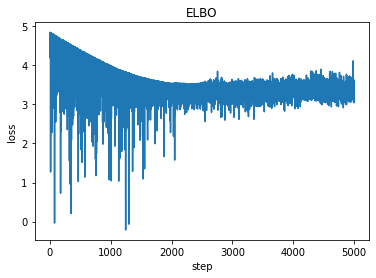

In [13]:
measurements = torch.tensor([40.])
guesses = torch.tensor([41.])

pyro.clear_param_store()
svi = pyro.infer.SVI(model=deferred_conditioned_speedometer,
                     guide=speedometer_parametrized_guide_constrained,
                     optim=pyro.optim.SGD({"lr": 1e-3}),
                     loss=pyro.infer.Trace_ELBO())

losses, scales = [], []
n_steps = 5_000
for t in trange(n_steps):
    losses.append(svi.step(guesses, measurements))
    scales.append(pyro.param("scale").item())
    
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
print(f"scale = {pyro.param('scale').item()}")


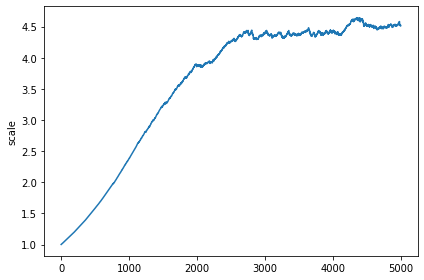

In [14]:
plt.ylabel('scale')
plt.plot(scales)
plt.tight_layout()

Notice, that we will load the parameter values from the parameter store - that's where Pyro stores them throughout training.


In [15]:
dict(pyro.get_param_store())

{'scale': tensor(4.5146, grad_fn=<AddBackward0>)}

Excercise
---------


1. Create a guide for coin flipping model, with starting param value $p = 0.5$. Train a model, show a plot of how loss and predicted probability varies.


In [0]:
def flip_coin():
    # copy from previous notebook
    pass

def flip_coin_guide():
    pass


In [0]:
lr = 1e-3
n_steps = 2500

pyro.clear_param_store()
svi = pyro.infer.SVI() # fill arguments

losses, probas = [], []
# write training loop

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
print(f"p = {pyro.param('p').item()}")
plt.show()

plt.subplot(1,1,1)
plt.plot(probas)
plt.ylabel('probability')
plt.tight_layout()
plt.show()
